# LDDMM: importance of the data attachment term

In [1]:
import shutil
from pathlib import Path

import numpy as np
import pyvista as pv
from matplotlib import pyplot as plt

import polpo.lddmm as plddmm
from polpo.mesh.geometry import centroid2farthest_vertex, vertexwise_euclidean
from polpo.mesh.surface import PvSurface
from polpo.mesh.varifold.tuning import SigmaFromLengths
from polpo.plot.pyvista import RegisteredMeshesColoredPlotter
from polpo.preprocessing.load.pregnancy.deformetrica import (
    get_two_random_maternal_meshes,
)

[KeOps] Warning : CUDA was detected, but driver API could not be initialized. Switching to CPU only.


In [2]:
RECOMPUTE = False

STATIC_VIZ = True
VIZ = 1

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [3]:
STRUCT_NAME = "L_Hipp"


OUTPUTS_DIR = Path.home() / ".polpo/results" / f"lddmm_data_attachment_{STRUCT_NAME}"
REGISTRATION_DIR = OUTPUTS_DIR / "registration"


if OUTPUTS_DIR.exists() and RECOMPUTE:
    shutil.rmtree(OUTPUTS_DIR)

In [4]:
meshes = get_two_random_maternal_meshes(
    OUTPUTS_DIR,
    mesh_names=("source", "target"),
)

In [5]:
if VIZ > 1:
    pl = pv.Plotter(border=False)

    for mesh in meshes:
        pl.add_mesh(mesh.as_pv(), show_edges=True, opacity=0.6)

    pl.show()

Following [LDDMM: how to register a mesh to a template?](./lddmm_register_mesh_template.ipynb).

In [6]:
registration_kwargs = dict(
    kernel_width=4.0,
    regularisation=1.0,
    max_iter=2000,
    freeze_control_points=False,
    tol=1e-16,
)

registration_dirs = []
mesh_filenames = list(meshes.keys())

In [7]:
sigma_search = SigmaFromLengths(
    ratio_charlen_mesh=2.0,
    ratio_charlen=0.25,
)
sigma_search.fit(meshes.values())

varifold_metric = sigma_search.optimal_metric_

In [8]:
metric = "landmark"
registration_dir = REGISTRATION_DIR / metric
registration_dirs.append(registration_dir)


if not registration_dir.exists():
    plddmm.registration.estimate_registration(
        mesh_filenames[0],
        mesh_filenames[1],
        metric=metric,
        output_dir=registration_dir,
        **registration_kwargs,
    )

NB: `use_svf=True` affects the deformation model, not the data attachment term. 

In [9]:
metric = "landmark"
registration_dir = REGISTRATION_DIR / f"{metric}_svf"
registration_dirs.append(registration_dir)


if not registration_dir.exists():
    plddmm.registration.estimate_registration(
        mesh_filenames[0],
        mesh_filenames[1],
        use_svf=True,
        metric=metric,
        output_dir=registration_dir,
        **registration_kwargs,
    )

In [10]:
metric = "varifold"
registration_dir = REGISTRATION_DIR / metric
registration_dirs.append(registration_dir)


if not registration_dir.exists():
    plddmm.registration.estimate_registration(
        mesh_filenames[0],
        mesh_filenames[1],
        metric=metric,
        output_dir=registration_dir,
        attachment_kernel_width=sigma_search.sigma_,
        **registration_kwargs,
    )

In [11]:
metric = "varifold"
registration_dir = REGISTRATION_DIR / f"{metric}_svf"
registration_dirs.append(registration_dir)


if not registration_dir.exists():
    plddmm.registration.estimate_registration(
        mesh_filenames[0],
        mesh_filenames[1],
        metric=metric,
        use_svf=True,
        output_dir=registration_dir,
        attachment_kernel_width=sigma_search.sigma_,
        **registration_kwargs,
    )

In [12]:
source, target = meshes.values()

reconstructed = {}
for registration_dir in registration_dirs:
    reconstructed[registration_dir.name] = PvSurface(
        plddmm.io.load_deterministic_atlas_reconstruction(registration_dir, as_pv=True)
    )

reconstructed["source"] = source

In [13]:
{
    name: varifold_metric.dist(target, reconstructed_)
    for name, reconstructed_ in reconstructed.items()
}

{'landmark': np.float64(1765.1354585768365),
 'landmark_svf': np.float64(296.33684090870776),
 'varifold': np.float64(6.990949834731759),
 'varifold_svf': np.float64(7.59546796117099),
 'source': np.float64(137.23227322800554)}

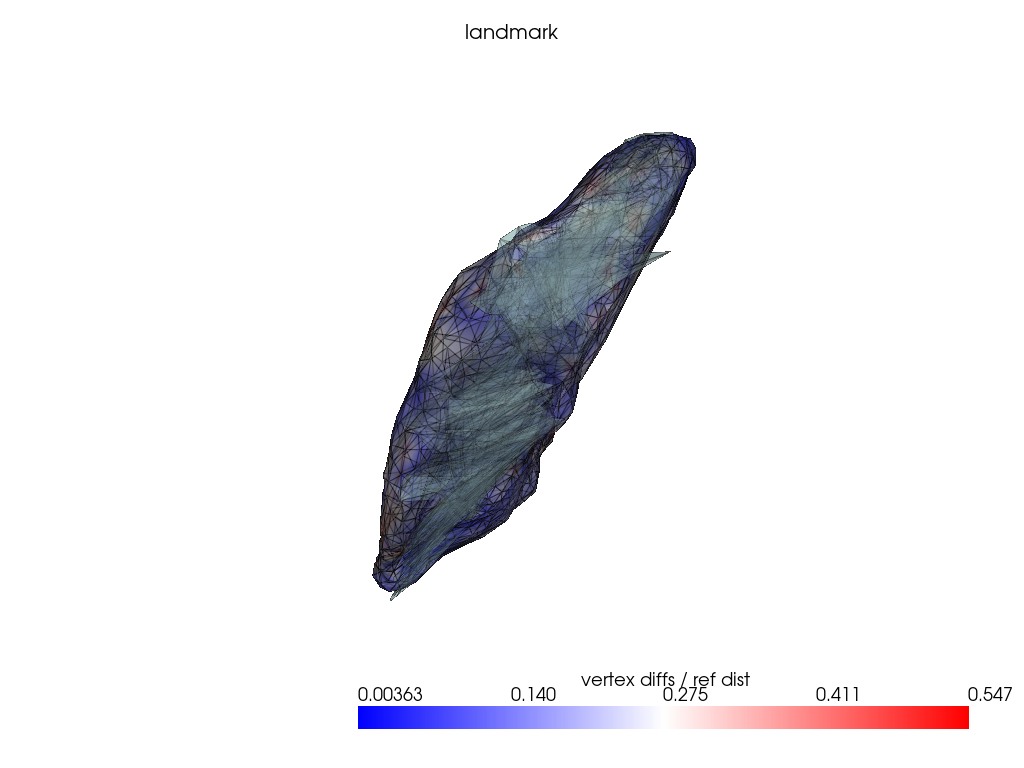

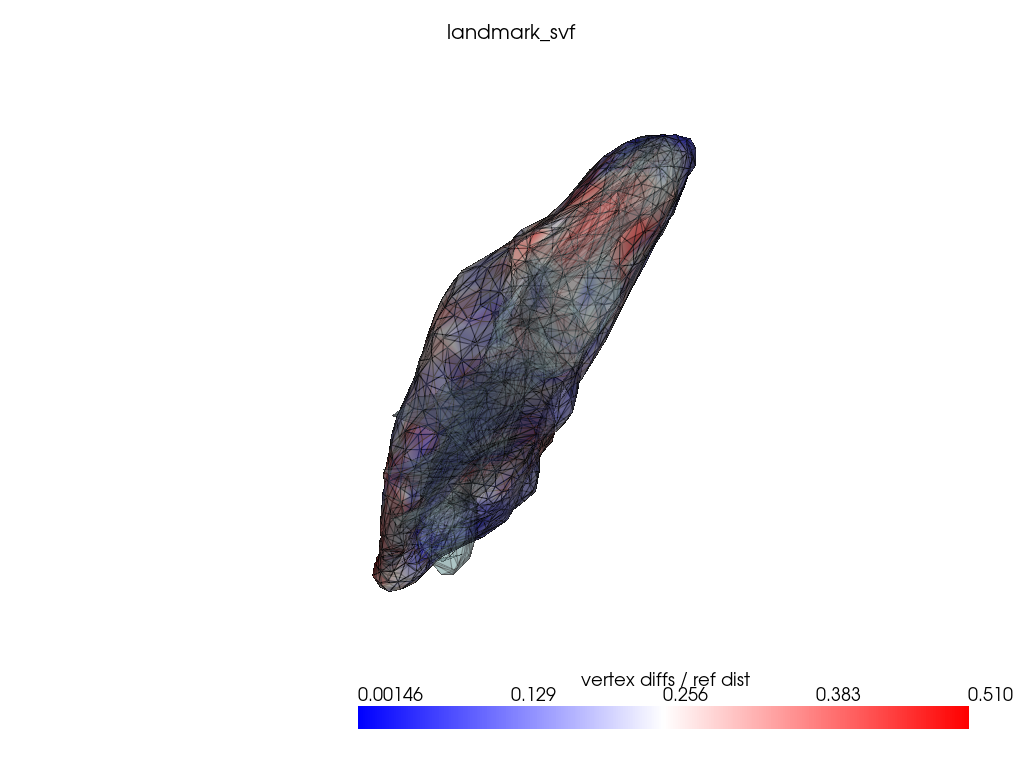

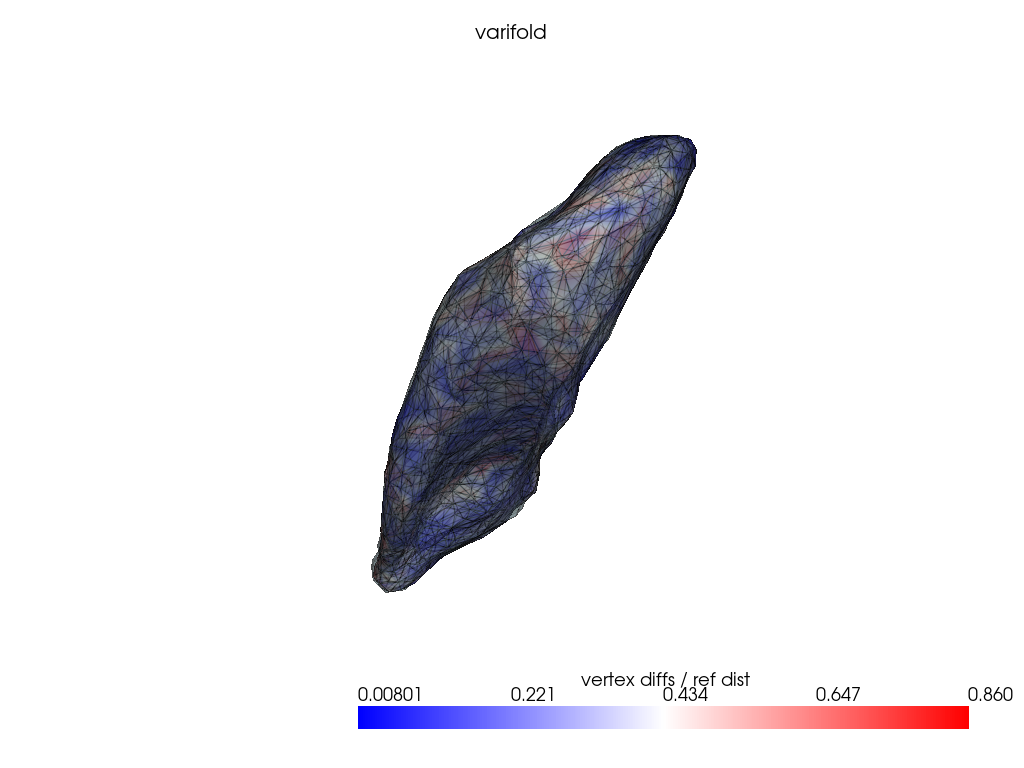

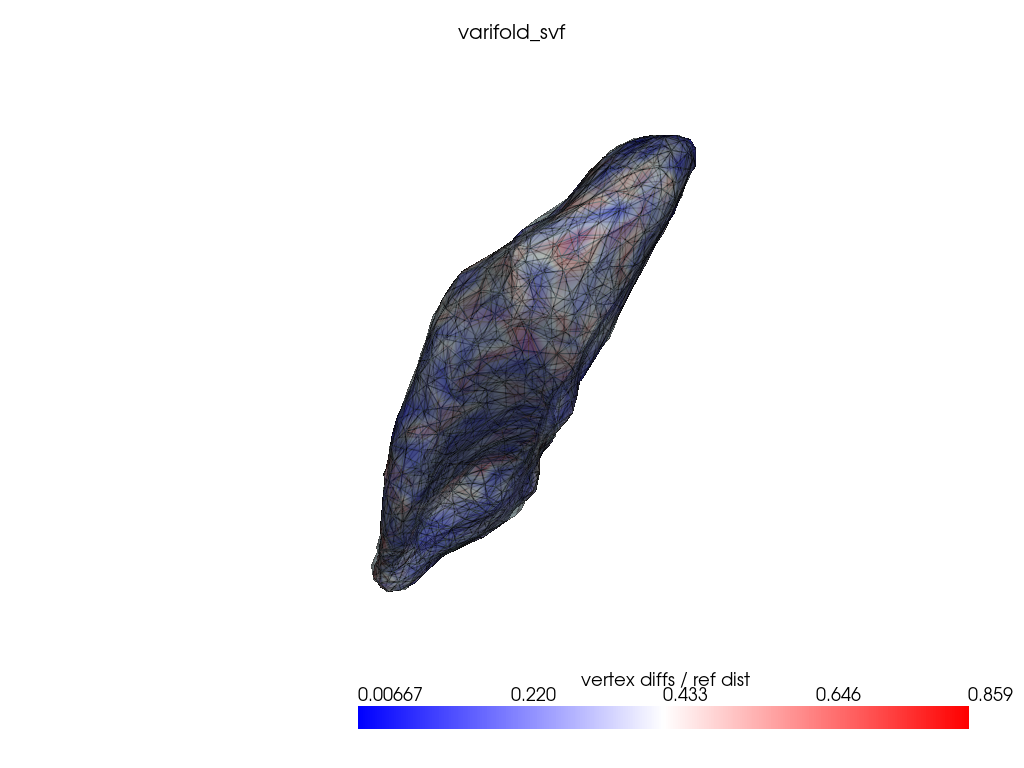

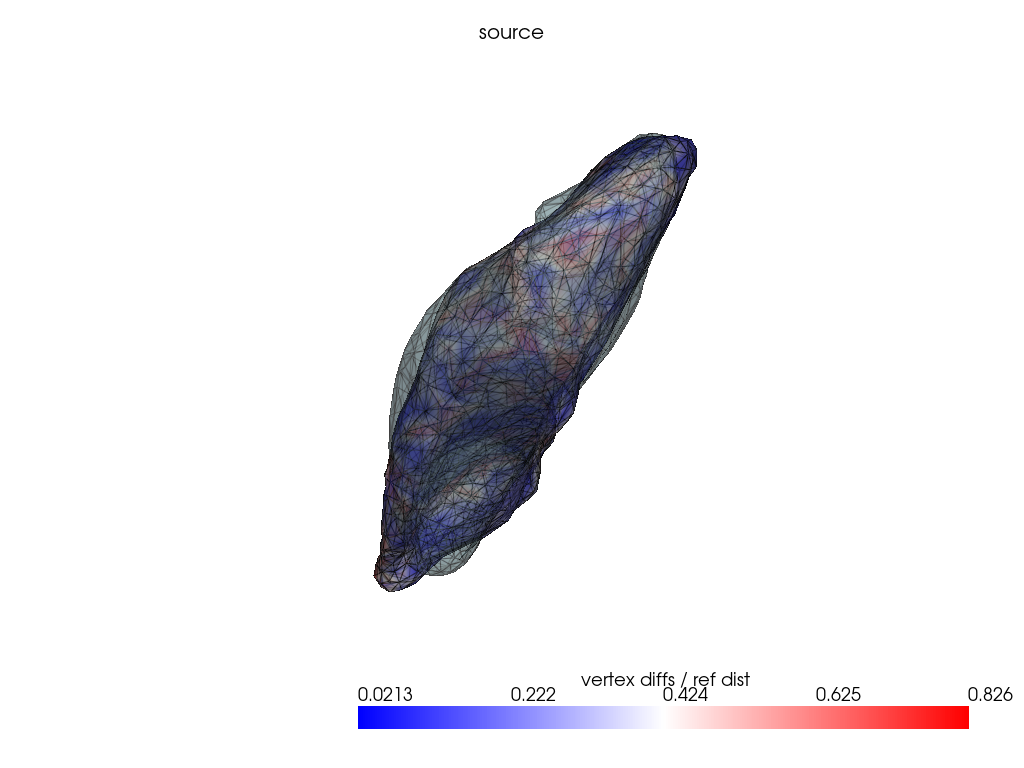

In [14]:
if VIZ > 0:
    ref_dist = centroid2farthest_vertex([target])[0]

    for name, reconstructed_ in reconstructed.items():
        pl = RegisteredMeshesColoredPlotter()

        pl.add_meshes(
            target.as_pv(),
            reconstructed_.as_pv(),
            ref_dist=ref_dist,
            show_edges=True,
            opacity=0.8,
            name="vertex diffs / ref dist",
        )

        pl.add_mesh(reconstructed_.as_pv(), show_edges=True, opacity=0.5)

        pl.add_title(name, font_size=8.0)

        pl.show()

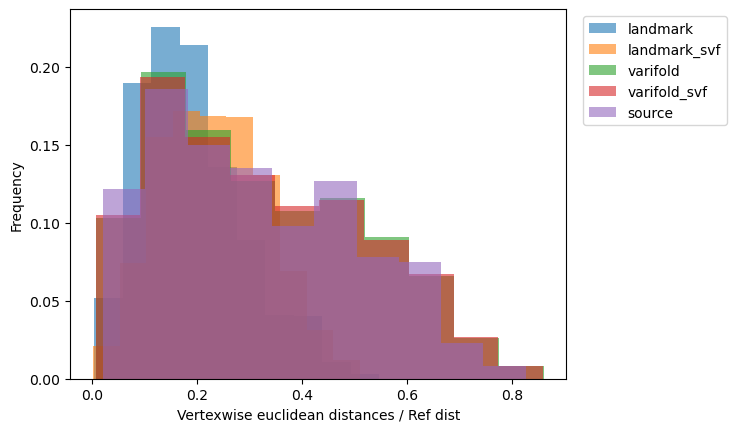

In [15]:
_, ax = plt.subplots()

for name, reconstructed_ in reconstructed.items():
    vals = vertexwise_euclidean(target, reconstructed_) / ref_dist

    ax.hist(
        vals,
        weights=1 / len(vals) * np.ones_like(vals),
        label=name,
        alpha=0.6,
    )

ax.set_xlabel("Vertexwise euclidean distances / Ref dist")
ax.set_ylabel("Frequency")

ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left");